In [1]:
'''The plan is to simulate stellar mass following the well-known IMF to obtain a random star
out of 10.000 generated or take them all and test them with a selected randomly pair of (M, P) 
and compute the eclipsing time and probabilities many times to obtain the final dependence 
of number of transits with stellar mass.'''

#Standard python packages

from astropy import constants as c
from math import factorial as fac
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import numpy as np
import IMF_Generator
from astropy.table import Table

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')
%matplotlib inline

In [2]:
'''Functions and definitions used along the distributions'''

G         = 2.959e-4           # AU^3 / Msun day^2
Masses_CF = 9.5458e-4          #From jupiter mass to solar mass

def MajorAxis(M, m, P):
    
    #M and m in solar mass, P in days = Major axis in AU
    return (G * (M + m) / (4.0*np.pi**2))                      **(1.0/3.0) * P**(2.0/3.0)

def Eclipsing_Time(M, m, P, epsilon):
    return P * (epsilon / np.pi) * (m / (2.0*M))**(1.0/3.0)

def ocurrence(a, m, M, R, e, epsilon):
    #a in AU, m and M in solar mass, R in AU
    
    RH = epsilon * ( a*(1 - e)*(m / (3.0*M) )**(1.0/3.0) )
    #return R/a              #Point-planet
    return (RH + R) / a      #Hill sphere radius

def Real_prob(Gaia_lifetime, Eclipsing_duration, Trials):
    return 1.0 - ( (Gaia_lifetime - Eclipsing_duration) / Gaia_lifetime )**Trials

def Prob_total(p1, p2, p3, p4):
    return np.array(p1*p2*p3*p4)

In [3]:
#Have in mind that Planet_period here is the same as 
#Gaia lifetime. Change if needed !!! 

Star_mass     = np.linspace(0.1, 10, 10000)
Planet_mass   = 0.0095458                #Planet mass will be stored here (M_sun, 10Mj)
Planet_period = 1825.0 

Planet_maxis  = np.array(MajorAxis(Star_mass, Planet_mass, Planet_period))
R_sun         = 0.00465                                #In AU
# R_star        = np.array(R_sun * (Star_mass)**0.8)   #Following a Main Sequence Mass-to-Radius relation

#=========================================================================================================
'''New way to compute the stellar radius from isochrones'''

Radius_Mass_Isochrones = Table.read('Radius_Mass_Model.dat', format = 'ascii', data_start = 0, fast_reader = True)
# Radius_Mass_Isochrones = Table.read('Radius_Mass_Model_1.dat', format = 'ascii', data_start = 0, fast_reader = True)
Mass                   = Radius_Mass_Isochrones['col1']
Radius                 = Radius_Mass_Isochrones['col2']
  
R_star = []    
for k in range(len(Star_mass)):
# for k in range(3):
#     print("Original %f %i"%(Star_mass[k], k))
    Model = []
    for i in range(len(Radius_Mass_Isochrones)):
        if ((Mass[i] + 0.058*Mass[i]) >= (Star_mass[k])) and ((Mass[i] - 0.058*Mass[i]) <= (Star_mass[k])):
#             print("Test %f %f"%(Mass[i], Radius[i]))
#             Radii = R_sun *np.exp(Radius[i])
            Model.append(np.exp(Radius[i]))
            
#     print(Model, np.median(Model))  
    R_star.append(R_sun * np.median(Model))
                        
R_star = np.array(R_star)   
# R_star.shape
#=========================================================================================================

Prob   = ocurrence(Planet_maxis, Planet_mass, Star_mass, R_star, e = 0.0, epsilon = 0.3)
E_time = Eclipsing_Time(Star_mass, Planet_mass, Planet_period, epsilon = 0.3)

P1     = 0.17                                   #Cassen et al. 2012 for (0.3-10M_J) within (0.5-10AU)
P2     = 1.00                                   #Best case
P3     = Prob                                   #Planet_mass = 10M_J, Planet_period = 5yr, epsilon = 0.3
P4     = Real_prob(Planet_period, E_time, 70.0) #Gaia NO-observation probability

In [4]:
# R_star

# np.savetxt('TEST.dat', np.c_[R_star, Star_mass], delimiter = ',')

In [5]:
# R_star

In [6]:
# #Esto no funciona todavia, hay que ver como encontrar el numeroa decuado
# #Kroupa fue cambiado a 0.01 y 50 para poder hallar la constante correcta.
# #===========================================================================================================

# #Total number of stars in one bin
# #I need to take into account the total number of simualted stars to weight properly
# #Also look at Kroupa's paper and see if there's a constant in front of the relation
# #between the number of stars and the stellar mass


# C = 7531*( (1/(1-1.3))*(0.5**(1-1.3) - 0.1**(1-1.3)) )**-1
# print('C  = %i'%C)

# CC = 2713*( (1/(1-2.3))*(10**(1-2.3) - 0.5**(1-2.3)) )**-1
# print('CC = %i'%CC)

Weight = ((0.5)**(1-1.3) - (0.1)**(1-1.3) )/ (1-1.3) +  ( ((10)**(1-2.3) - (0.5)**(1-2.3) )/ (1-2.3) )*(0.5)**(1-2.3-1+1.3)
B2 = 10000./Weight
B1 = 10000.*(0.5)**(1-2.3-1+1.3)/Weight

# B2  = 1598.
# B1  = 3196.


Number = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

alpha           = [1.3, 2.3]
NUMBER_OF_STARS = []

for i in range(len(Number) - 1):
#     print(i,Number[i],Number[i+1])
    
    if Number[i] < 0.5:
#     if i < 1:
        
        Bin             = (1.0/(1.0-alpha[0]))*(Number[i+1]**(1.0-alpha[0]) - Number[i]**(1.0-alpha[0]))
        NUMBER_OF_STARS.append(Bin*B1)
    
    if Number[i] >= 0.5:
#     if i >= 1:
        
        Bin             = (1.0/(1.0-alpha[1]))*(Number[i+1]**(1.0-alpha[1]) - Number[i]**(1.0-alpha[1]))
        NUMBER_OF_STARS.append(Bin*B2)
            
NUMBER_OF_STARS = np.ceil(NUMBER_OF_STARS)

# #===========================================================================================================
# print(NUMBER_OF_STARS)


In [7]:
Planet_mass   = 0.0095458                #Planet mass will be stored here (M_sun, 10Mj)
Planet_period = 1825.0 
R_sun         = 0.00465                  #In AU

def Test(Star_mass, Planet_mass, Planet_period):
    return 0.17*1.0*ocurrence(MajorAxis(Star_mass, Planet_mass, Planet_period), \
                   Planet_mass, Star_mass, (R_sun * (Star_mass)**0.8), e = 0.0, epsilon = 0.3)*Real_prob(Planet_period, \
                   Eclipsing_Time(Star_mass, Planet_mass, Planet_period, epsilon = 0.3), 70.0)

Discret_Stellar_Mass    = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
StarMass_bin            = []

Probability_Integration = []

for i in range(len(Discret_Stellar_Mass)-1):
    
    A = (Discret_Stellar_Mass[i]+Discret_Stellar_Mass[i+1])/2.0
    StarMass_bin.append((Discret_Stellar_Mass[i]+Discret_Stellar_Mass[i+1])/2.0)
    
#     if Discret_Stellar_Mass[i] < 0.5:
# #         print(Test(, Planet_mass, Planet_period))
#         print(Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1])
#         Result = integrate.quad(lambda x: NUMBER_OF_STARS[i]*Test(x, Planet_mass, Planet_period), Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1])
        
#     if Discret_Stellar_Mass[i] >= 0.5:
#         Result = integrate.quad(lambda x: NUMBER_OF_STARS[i]*Test(x, Planet_mass, Planet_period), Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1])
# #     print(i, A, Result[0], NUMBER_OF_STARS[i])
#     Probability_Integration.append(Result[0])
    
    
    if Discret_Stellar_Mass[i] < 0.5:
         
        X      = np.linspace(Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1], NUMBER_OF_STARS[i])
        Y      = Test(X, Planet_mass, Planet_period)
        
        Result = integrate.simps(Y, x = None, dx = NUMBER_OF_STARS[i])
        Result = Result/NUMBER_OF_STARS[i]
       
    if Discret_Stellar_Mass[i] >= 0.5:
        
        X      = np.linspace(Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1], NUMBER_OF_STARS[i])
        Y      = Test(X, Planet_mass, Planet_period)
        
        Result = integrate.simps(Y, x = None, dx = NUMBER_OF_STARS[i])
        Result = Result/NUMBER_OF_STARS[i] 
        
#     del X, Y
    Probability_Integration.append(Result)
#     del Result
# print(Probability_Integration[0],Probability_Integration[1],Probability_Integration[2])

# print(np.sum( Test(np.linspace(0.1, 0.5, 8141), Planet_mass, Planet_period)) )
# print(Probability_Integration)

/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [8]:
To_Compare_x  = Star_mass
To_Compare_y  = Test(Star_mass, Planet_mass, Planet_period)

To_Compare_xx = StarMass_bin
To_Compare_yy = Probability_Integration

Text(0.5, 1.0, 'One planet (10M$_J$, 5yr)')

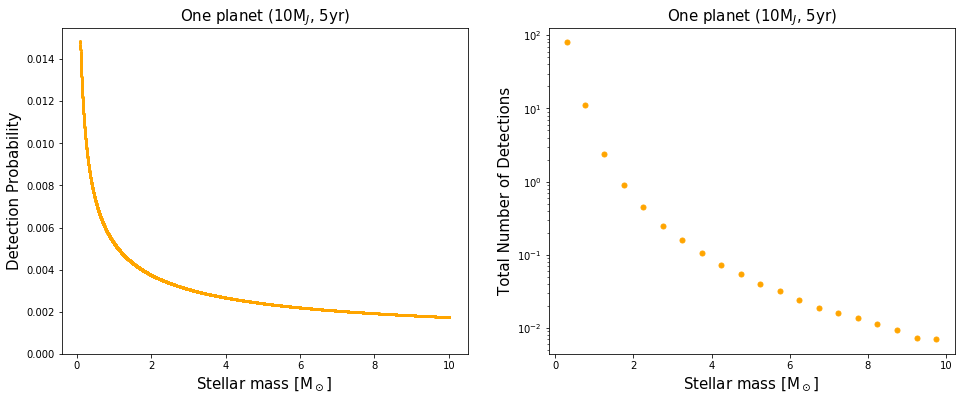

In [7]:
fig, ((axA, axB)) = plt.subplots(figsize = (16,6), nrows = 1, ncols = 2)

axA.scatter(Star_mass, Test(Star_mass, Planet_mass, Planet_period), s = 4, c= 'orange')
axA.set_xlabel(r'Stellar mass [M$_\odot$]', size = 15)
axA.set_ylabel('Detection Probability', size = 15)
axA.set_title( r'One planet (10M$_J$, 5yr)', size = 15)
axA.set_ylim(0, 0.0155)

axB.plot(StarMass_bin, Probability_Integration,'.', ms = 10, color = 'orange')
axB.set_yscale('log')
axB.set_xlabel(r'Stellar mass [M$_\odot$]', size = 15)
axB.set_ylabel('Total Number of Detections', size = 15)
axB.set_title( r'One planet (10M$_J$, 5yr)', size = 15)

# plt.savefig('Analytical.png', dpi = 300)
# print(Probability_Integration)

/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type 

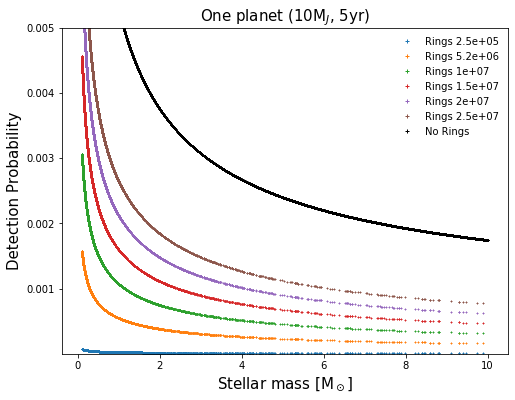

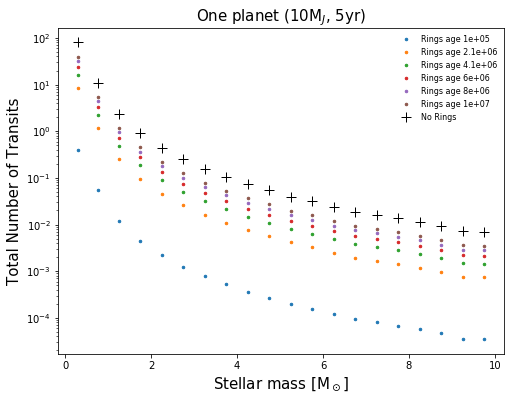

In [14]:
#Test with different values for rings lifetime

# Rings_Timescale = np.linspace(1e5, 1e7, 10) / 20e6
Rings_Timescale = np.linspace(1e5, 1e7, 6) / 20e6


plt.figure(figsize = (8,6))

for i in range(len(Rings_Timescale)):
    
    plt.plot(Star_mass, Prob_total(P1, P2, P3, P4)*Rings_Timescale[i], '+', ms = 2, label = 'Rings %.2g'%(Rings_Timescale[i]*50e6))

plt.plot(To_Compare_x, To_Compare_y, '+', ms = 2, color = 'black', label = 'No Rings')    
plt.xlabel(r'Stellar mass [M$_\odot$]', size = 15)
plt.ylabel('Detection Probability', size = 15)
plt.title( r'One planet (10M$_J$, 5yr)', size = 15)
plt.legend(frameon = False, loc = 'best', prop = {'size': 10}, markerscale = 2)
plt.ylim(0.000001, 0.005)

plt.savefig('Analytical_2.png', dpi = 300)

plt.figure(figsize = (8,6))

for j in range(len(Rings_Timescale)):
    
    Discret_Stellar_Mass    = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
    StarMass_bin            = []

    Probability_Integration = []

    for i in range(len(Discret_Stellar_Mass)-1):

        A = (Discret_Stellar_Mass[i]+Discret_Stellar_Mass[i+1])/2.0
        StarMass_bin.append((Discret_Stellar_Mass[i]+Discret_Stellar_Mass[i+1])/2.0)
        
        if Discret_Stellar_Mass[i] < 0.5:
             
            X      = np.linspace(Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1], NUMBER_OF_STARS[i])
            Y      = Test(X, Planet_mass, Planet_period)
        
            Result = integrate.simps(Y, x = None, dx = NUMBER_OF_STARS[i])
            Result = Rings_Timescale[j]*Result/NUMBER_OF_STARS[i]
       
        if Discret_Stellar_Mass[i] >= 0.5:
        
            X      = np.linspace(Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1], NUMBER_OF_STARS[i])
            Y      = Test(X, Planet_mass, Planet_period)
        
            Result = integrate.simps(Y, x = None, dx = NUMBER_OF_STARS[i])
            Result = Rings_Timescale[j]*Result/NUMBER_OF_STARS[i]         
        
    
#         if Discret_Stellar_Mass[i] < 0.5:
#             Result = integrate.quad(lambda x: Rings_Timescale[j]*NUMBER_OF_STARS[i]*Test(x, Planet_mass, Planet_period), Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1])
        
#         if Discret_Stellar_Mass[i+1] > 0.5:
#             Result = integrate.quad(lambda x: Rings_Timescale[j]*NUMBER_OF_STARS[i]*Test(x, Planet_mass, Planet_period), Discret_Stellar_Mass[i], Discret_Stellar_Mass[i+1])
    
        Probability_Integration.append(Result)
    

    plt.plot(StarMass_bin, Probability_Integration, '.', ms = 5, label = 'Rings age %.2g'%(Rings_Timescale[j]*20e6))

plt.plot(To_Compare_xx, To_Compare_yy, '+', ms = 10, color = 'black', label = 'No Rings')
plt.xlabel(r'Stellar mass [M$_\odot$]', size = 15)
plt.ylabel('Total Number of Transits', size = 15)
plt.title( r'One planet (10M$_J$, 5yr)', size = 15)
plt.yscale('log')
plt.legend(frameon = False, loc = 'best', prop = {'size': 8}, markerscale = 1)

# plt.savefig('Analytical_2_1.png', dpi = 300)

In [50]:
'''Stellar Mass Distribution
Assuming stellar mass follows a Kroupa IMF with slopes 0.3(m < 0.08), 1.3(0.08 < m < 0.5) and 2.3(0.5 < m)
Stellar mass from 0.1 to 10 solar masses'''

# Andt Schmitt Masses

M_AndtSchmitt = Table.read('/Users/lam/Downloads/Exoplanet-Rings-and-Gaia-master/3_First_Model/masses_all_new.txt', format = 'ascii')
M_AndtSchmitt_binned = Table.read('/Users/lam/Downloads/Exoplanet-Rings-and-Gaia-master/3_First_Model/masses_grouped_new.txt', format = 'ascii')

# Creating an array with all the masses repeated as in the table
M_AndtSchmitt_all = []
for i in range(len(M_AndtSchmitt)):
    masses = np.repeat(M_AndtSchmitt['col1'][i], M_AndtSchmitt['col2'][i])
    M_AndtSchmitt_all.append(masses)

# Joining the array of arrays into a single array    
M_AndtSchmitt_final = [j for i in M_AndtSchmitt_all for j in i]

slopes   = [1.3, 2.3]  #Inside the script is already negative
masslims = [0.1, 0.5, 10]
myimf = IMF_Generator.MultiPartPowerLaw(np.array(slopes), np.array(masslims))
m     = np.linspace(masslims[0],masslims[-1],200)
lnpdf = myimf.pdf(m)
cdf   = myimf.cdf(m)
# N_2   = 10000
N_2   = 31500 # For Matthew and his MSc student
ranmass_2 = myimf.rvs(N_2)

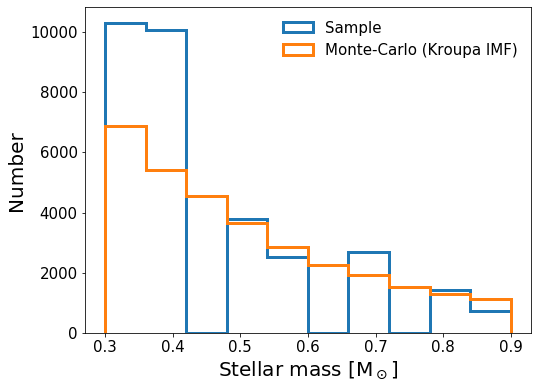

In [49]:
slopes   = [1.3, 2.3]  #Inside the script is already negative
masslims = [np.min(M_AndtSchmitt['col1']), 0.5, np.max(M_AndtSchmitt['col1'])]
myimf = IMF_Generator.MultiPartPowerLaw(np.array(slopes), np.array(masslims))
m     = np.linspace(masslims[0],masslims[-1],200)
lnpdf = myimf.pdf(m)
cdf   = myimf.cdf(m)
# N_2   = 10000
N_2   = 31500 # For Matthew and his MSc student
ranmass_2 = myimf.rvs(N_2)

plt.figure(figsize = (8,6))
plt.hist(M_AndtSchmitt_final, histtype = 'step', lw = 3, label = 'Sample')
plt.hist(ranmass_2, histtype = 'step', lw = 3, label = 'Monte-Carlo (Kroupa IMF)')
plt.xlabel(r'Stellar mass [M$_\odot$]', size = 20)
plt.ylabel('Number', size = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, loc = 'best', prop = {'size': 15}, markerscale = 1)

# plt.savefig('IMF_distribution.png', dpi = 300, bbox_inches = 'tight')

In [51]:
ranmass_2 = M_AndtSchmitt_final

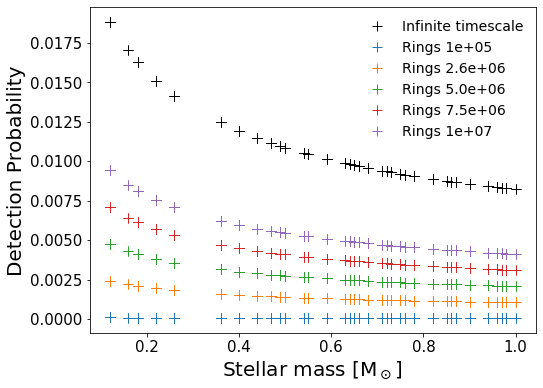

In [57]:
Star_mass     = np.sort(ranmass_2)
Planet_mass   = 10.0*Masses_CF #In solar mass
# Planet_period = 1825.0         #Days #Gaia
Planet_period = 27.0         #Days #For Matthew and his MSc student


Planet_maxis  = np.array(MajorAxis(Star_mass, Planet_mass, Planet_period))
R_sun         = 0.00465                              #In AU
# R_star        = np.array(R_sun * (Star_mass)**0.8)   #Following a Main Sequence Mass-to-Radius relation

#=========================================================================================================
'''New way to compute the stellar radius from isochrones'''

Radius_Mass_Isochrones = Table.read('Radius_Mass_Model.dat', format = 'ascii', data_start = 0, fast_reader = True)
Mass                   = Radius_Mass_Isochrones['col1']
Radius                 = Radius_Mass_Isochrones['col2']
  
R_star = []    
for k in range(len(Star_mass)):
# for k in range(3):
#     print("Original %f %i"%(Star_mass[k], k))
    Model = []
    for i in range(len(Radius_Mass_Isochrones)):
        if ((Mass[i] + 0.058*Mass[i]) >= (Star_mass[k])) and ((Mass[i] - 0.058*Mass[i]) <= (Star_mass[k])):
#             print("Test %f %f"%(Mass[i], Radius[i]))
#             Radii = R_sun *np.exp(Radius[i])
            Model.append(np.exp(Radius[i]))
            
#     print(Model, np.median(Model))  
    R_star.append(R_sun * np.median(Model))
                        
R_star = np.array(R_star)   
# R_star.shape
#=========================================================================================================

Prob   = ocurrence(Planet_maxis, Planet_mass, Star_mass, R_star, e = 0.0, epsilon = 0.3)
E_time = Eclipsing_Time(Star_mass, Planet_mass, Planet_period, epsilon = 0.3)

P1     = 0.17                                   #Cassen et al. 2012 for (0.3-10M_J) within (0.5-10AU)
P2     = 1.00                                   #Best case
P3     = Prob                                   #Planet_mass = 10M_J, Planet_period = 5yr, epsilon = 0.3
P4     = Real_prob(Planet_period, E_time, 70.0) #Gaia NO-observation probability

# Rings_Timescale = np.linspace(1e5, 1e7, 10) / 20e6
Rings_Timescale = np.linspace(1e5, 1e7, 5) / 20e6

plt.figure(figsize = (8,6))

plt.plot(Star_mass, Prob_total(P1, P2, P3, P4), '+', color = 'black', ms = 10, label = 'Infinite timescale')

for i in range(len(Rings_Timescale)):
    plt.plot(Star_mass, Prob_total(P1, P2, P3, P4)*Rings_Timescale[i], '+', ms = 10, label = 'Rings %.2g'%(Rings_Timescale[i]*20e6))
    
plt.xlabel(r'Stellar mass [M$_\odot$]', size = 20)
plt.ylabel('Detection Probability', size = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
# plt.title( r'One planet (10M$_J$, 5yr)', size = 15)
# plt.ylim(0.000001, 0.005)
# plt.xlim(-0.5,10)
plt.legend(frameon = False, loc = 'best', prop = {'size': 14}, markerscale = 1)
#print(np.sort(Star_mass))

# plt.savefig('fig1.png', dpi = 300, bbox_inches = 'tight')

# plt.figure(figsize = (8,6), dpi = 100)
# plt.scatter(Star_mass, Test(Star_mass, Planet_mass, Planet_period), s = 4, c= 'orange')
# plt.plot(Star_mass, Prob_total(P1, P2, P3, P4), '+', ms = 2, label = 'No Rings')
# plt.xlabel(r'Stellar mass [M$_\odot$]', size = 15)
# plt.ylabel('Detection Probability', size = 15)
# plt.title( r'One planet (10M$_J$, 5yr)', size = 15)
# plt.ylim(0, 0.0155)

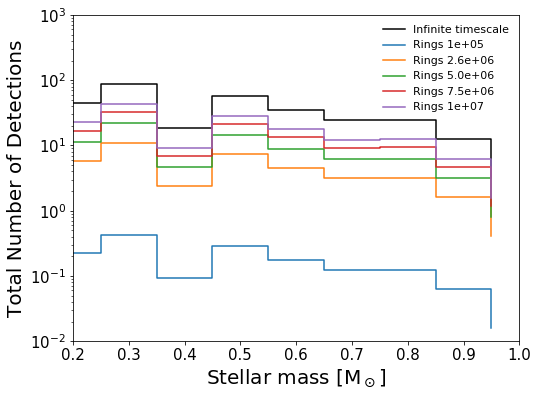

In [58]:
fig, ((axB)) = plt.subplots(figsize = (8,6), nrows = 1, ncols = 1)

# N = np.linspace(0.1, 10, 23)
# N = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
# N = M_AndtSchmitt_binned['col1']
N = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

AAA = np.array([Star_mass, Prob_total(P1, P2, P3, P4)])

Rings_Timescale = np.append(1.0, Rings_Timescale)

for k in range(len(Rings_Timescale)):
    AAA = np.array([Star_mass, Prob_total(P1, P2, P3, P4)*Rings_Timescale[k]])
    A = []
    NN = []
    NNN = []
    
    for i in range(len(N) -1):
    
        B = []
        NN.append( (N[i] + N[i+1])/2.0 )
        NNN.append((N[i] + N[i+1])/2.0 - N[i+1])
        for j in range(len(Star_mass)):
        
            if ((AAA[0:,j][0] > N[i]) and (AAA[0:,j][0] < N[i+1])):
                B.append(AAA[0:,j][1])
        A.append(np.sum(B)) 
    
    if k == 0:
        axB.step(NN, A, c ='black', where  = 'post', label = 'Infinite timescale') #0.45 ( (N[i] + N[i+1])/2 - N[i+1] )*2
    
    if k != 0:
        axB.step(NN, A, where  = 'post', label = 'Rings %.2g'%(Rings_Timescale[k]*20e6)) #0.45 ( (N[i] + N[i+1])/2 - N[i+1] )*2
        
axB.set_xlim(0.2, 1.0)
axB.set_ylim(1e-2, 1e3)
    
axB.set_yscale('log')
axB.set_xlabel(r'Stellar mass [M$_\odot$]', size = 20)
axB.set_ylabel('Total Number of Detections', size = 20)
# axB.set_title( r'One planet (10M$_J$, 5yr)', size = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
axB.legend(frameon = False, loc = 'upper right', prop = {'size': 11}, markerscale = 2)

plt.savefig('fig2.png', dpi = 300, bbox_inches = 'tight')

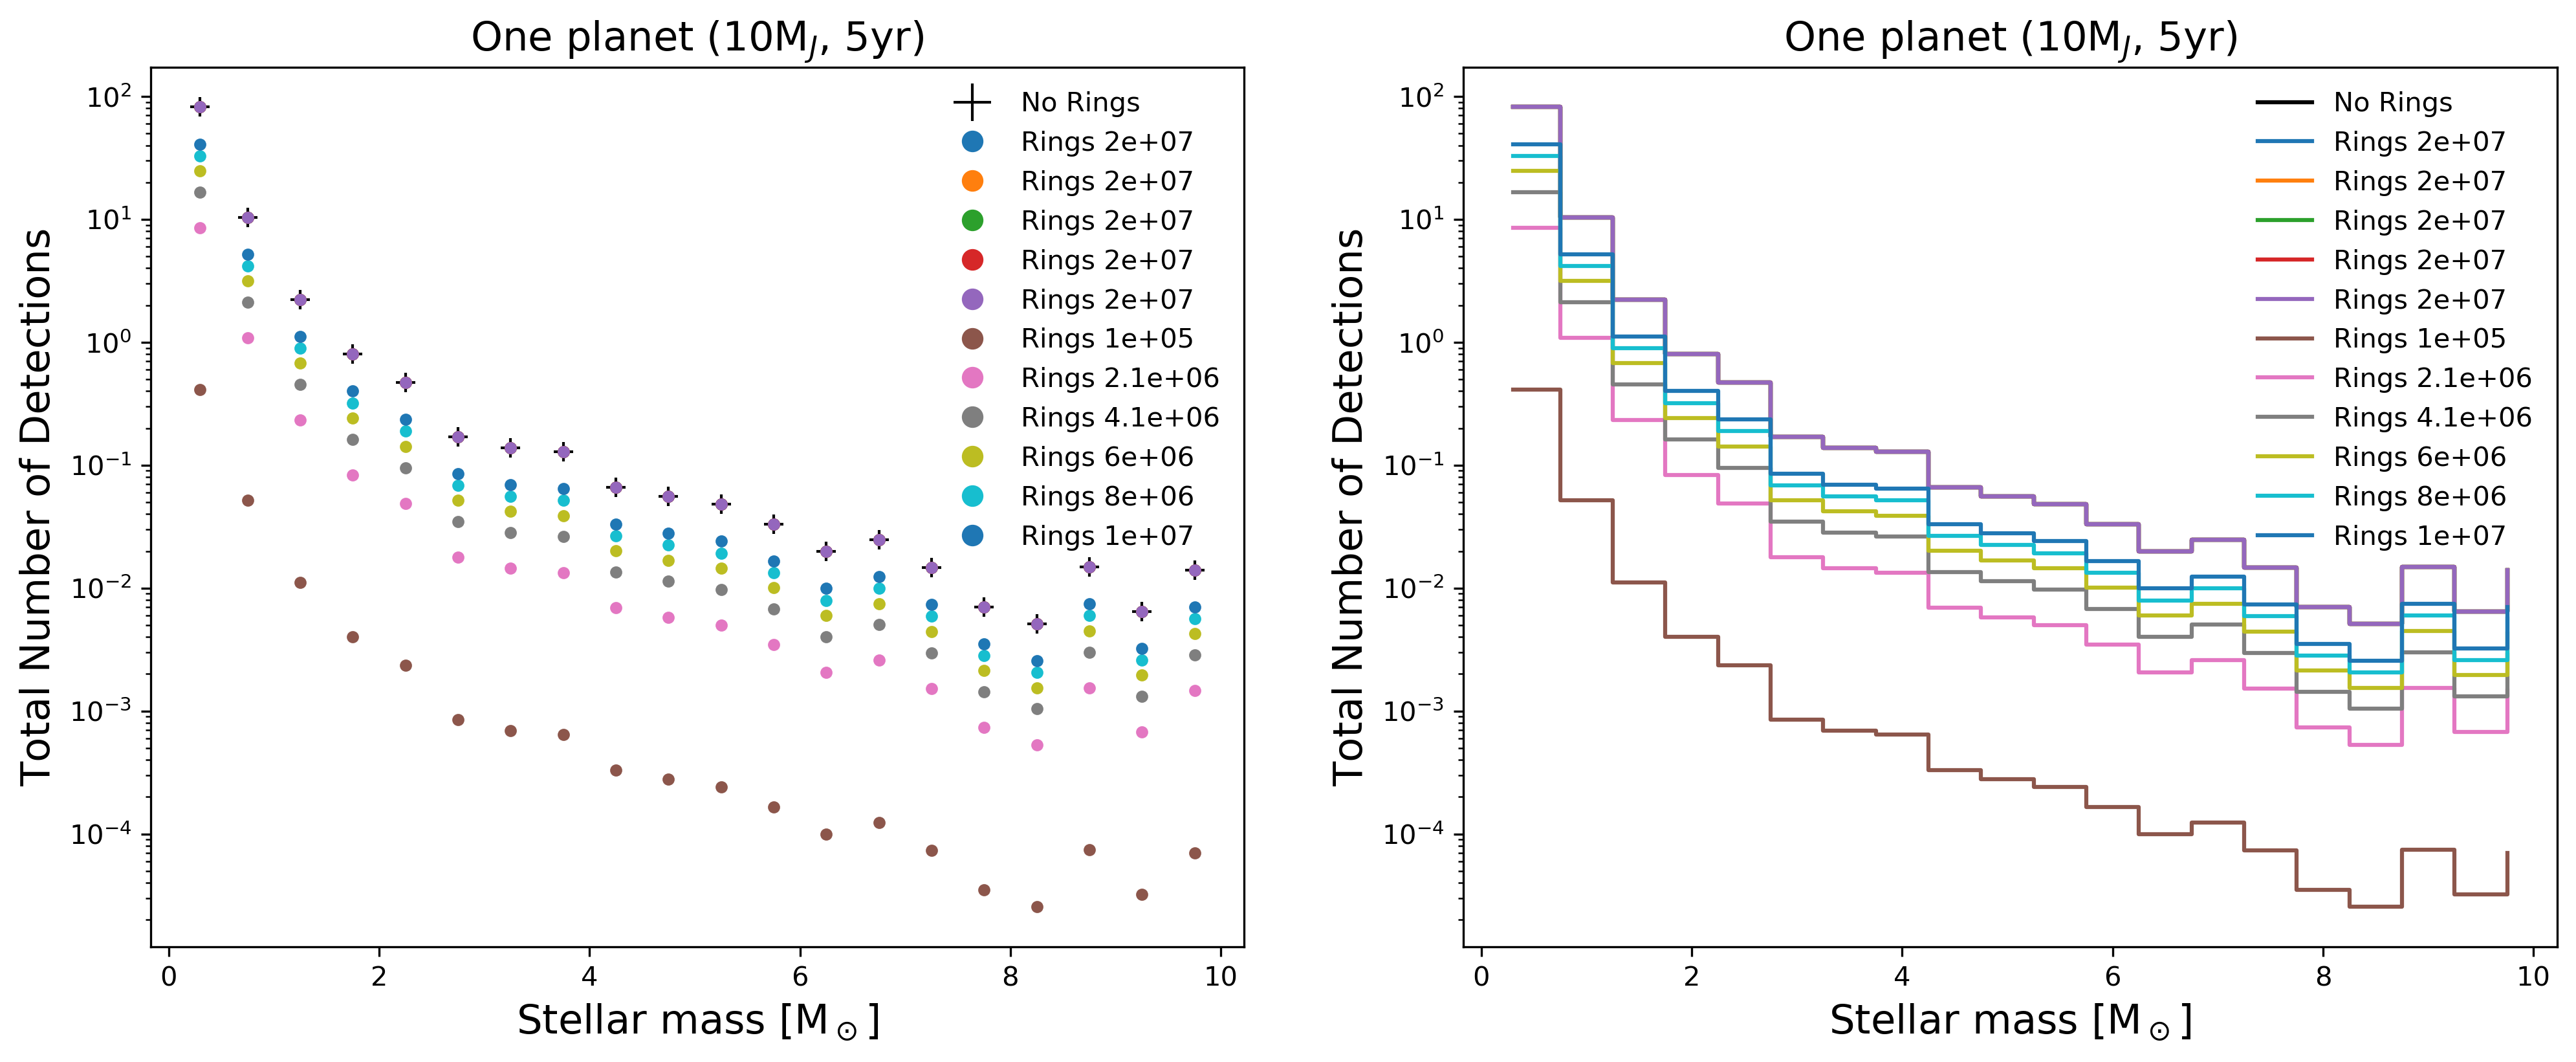

In [24]:
fig, ((axA, axB)) = plt.subplots(figsize = (16,6), nrows = 1, ncols = 2, dpi = 300)

# N = np.linspace(0.1, 10, 23)
N = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

#print(N)
AAA = np.array([Star_mass, Prob_total(P1, P2, P3, P4)])
#print(AAA[0:,][0])

Rings_Timescale = np.append(1.0, Rings_Timescale)

for k in range(len(Rings_Timescale)):
    AAA = np.array([Star_mass, Prob_total(P1, P2, P3, P4)*Rings_Timescale[k]])
    A = []
    NN = []
    NNN = []
    
    for i in range(len(N) -1):
    
        B = []
        NN.append( (N[i] + N[i+1])/2.0 )
        NNN.append((N[i] + N[i+1])/2.0 - N[i+1])
        for j in range(len(Star_mass)):
        
            if ((AAA[0:,j][0] > N[i]) and (AAA[0:,j][0] < N[i+1])):
                B.append(AAA[0:,j][1])
#         print(len(B))      
        A.append(np.sum(B)) 
    
    if k == 0:
        axA.plot(NN, A, '+', c ='black', ms = 7, label = 'No Rings')
        axB.step(NN, A, c ='black', where  = 'post', label = 'No Rings') #0.45 ( (N[i] + N[i+1])/2 - N[i+1] )*2
    
    if k != 0:
        axA.plot(NN, A, '.', ms = 7, label = 'Rings %.2g'%(Rings_Timescale[k]*20e6))
#     axA.plot(To_Compare_x, To_Compare_y, '+', ms = 10, color = 'black')
        axB.step(NN, A, where  = 'post', label = 'Rings %.2g'%(Rings_Timescale[k]*20e6)) #0.45 ( (N[i] + N[i+1])/2 - N[i+1] )*2

    
# print(N) 
axA.set_yscale('log')
axA.set_xlabel(r'Stellar mass [M$_\odot$]', size = 15)
axA.set_ylabel('Total Number of Detections', size = 15)
axA.set_title( r'One planet (10M$_J$, 5yr)', size = 15)
axA.legend(frameon = False, loc = 'best', prop = {'size': 10}, markerscale = 2)
# axA.set_ylim(1,30)

# axB.step(To_Compare_x, To_Compare_y, where  = 'post', color = 'black')
axB.set_yscale('log')
axB.set_xlabel(r'Stellar mass [M$_\odot$]', size = 15)
axB.set_ylabel('Total Number of Detections', size = 15)
axB.set_title( r'One planet (10M$_J$, 5yr)', size = 15)
axB.legend(frameon = False, loc = 'best', prop = {'size': 10}, markerscale = 2)

# plt.savefig('Analytical_4.png', dpi = 300)